<a href="https://colab.research.google.com/github/aishwaryavasu0509/Bleep-bllop/blob/main/Shareprice_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np


In [1]:
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
data = pd.read_csv('/Lab/Labsheet1.csv',sep=',', index_col='Month', parse_dates=['Month']).fillna(0)
print(data)

                Open      High       Low     Close
Month                                             
2000-01-01   5209.54   5668.28   5184.48   5205.29
2000-02-01   5217.65   6150.69   5127.79   5446.98
2000-03-01   5464.65   5828.79   4867.23   5001.28
2000-04-01   5070.50   5542.81   4284.17   4657.55
2000-05-01   4736.02   4757.89   3831.86   4433.61
...              ...       ...       ...       ...
2021-08-01  52901.28  57625.26  52804.08  57552.39
2021-09-01  57763.53  60412.32  57263.90  59126.36
2021-10-01  58889.77  62245.43  58551.14  59306.93
2021-11-01  59577.48  61036.56  56382.93  57064.87
2021-12-01  57365.85  59203.37  55132.68  58253.82

[264 rows x 4 columns]


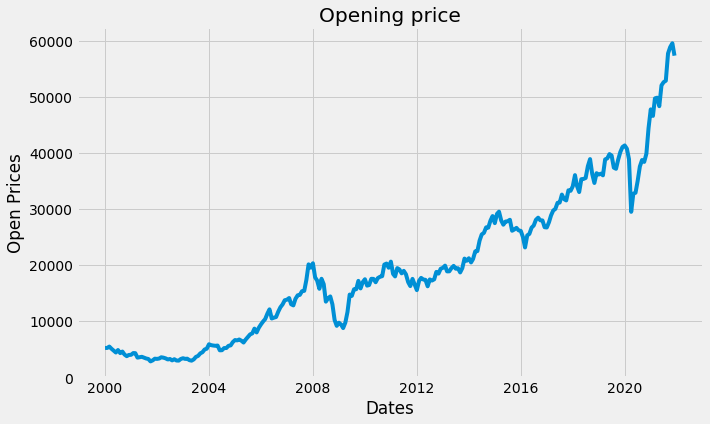

In [6]:
#Open price plot
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'])
plt.title('Opening price')
plt.show()



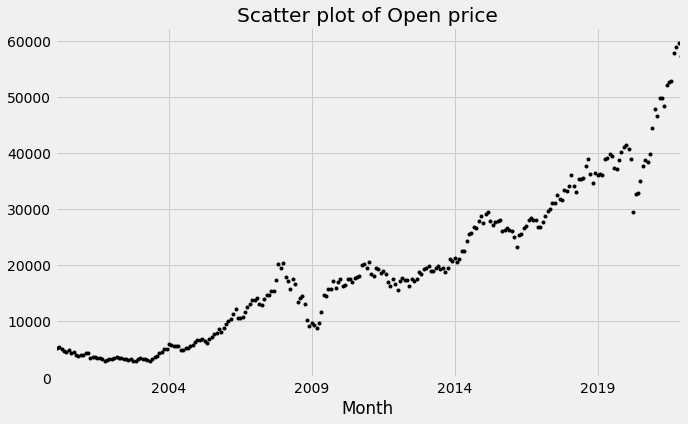

In [7]:
# scatter plot
df_close = data['Open']
df_close.plot(style='k.')
plt.title('Scatter plot of Open price')
plt.show()



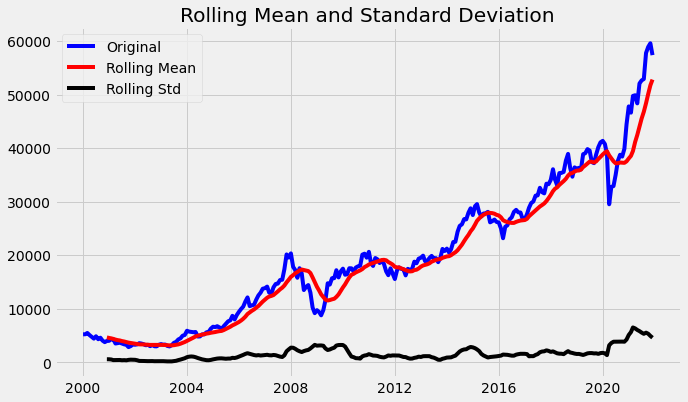

Results of dickey fuller test
Test Statistics                  1.497354
p-value                          0.997514
No. of lags used                 0.000000
Number of observations used    263.000000
critical value (1%)             -3.455461
critical value (5%)             -2.872593
critical value (10%)            -2.572660
dtype: float64


In [8]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

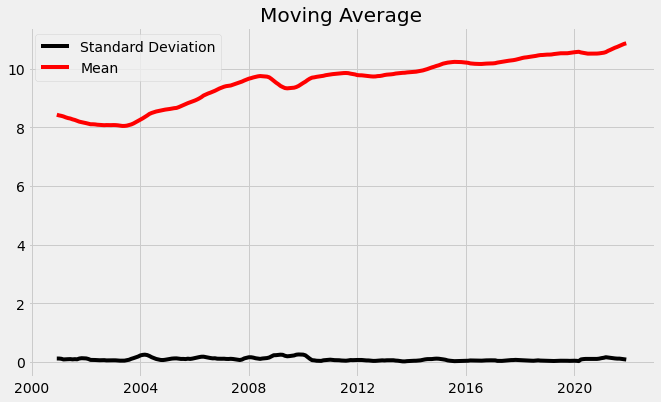

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()



**Arima model**

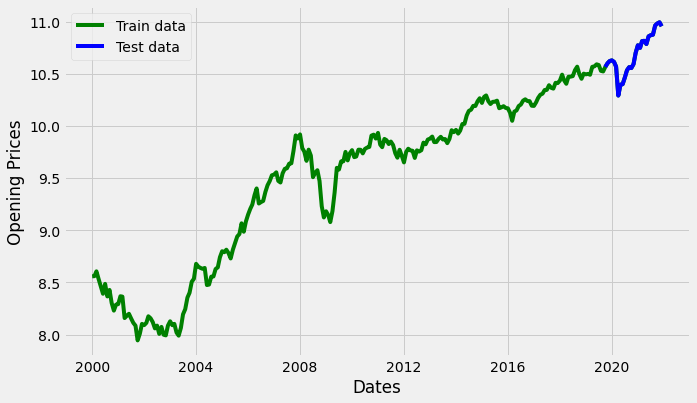

In [14]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Opening Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()



In [15]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-607.692, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-606.942, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-606.978, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-605.708, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-604.931, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.540 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 305.846
Date:                Mon, 26 Dec 2022   AIC                           -607.692
Time:                        06:03:56   BIC                           -600.790
Sample:                    04-01-2000   HQIC                          -604.909
                         - 09-01-2019                                       

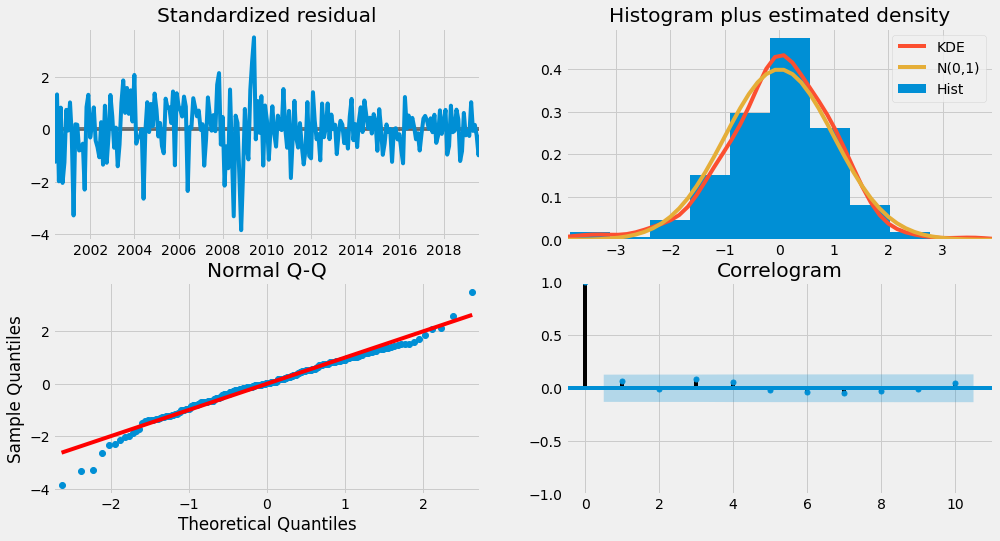

In [18]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()



**Value** **prediction**

In [28]:
# Forecast
fc, se, conf = fitted.forecast(544, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()




ValueError: ignored